# Problem Set 3


The basic dynamics of the Hodgkin-Huxley model is given by 

$ c{_m}* \frac{dV}{dt} = −i{_m} +I_e/A $


$ i{_m} =g{_L}(V −E{_L})+g{_K}n^{4}(V −E{_K})+g_{Na}m^{3}·h(V −E_{Na}) $



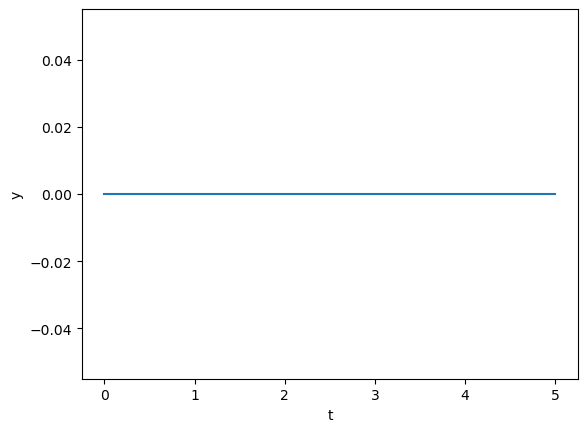

In [1]:
# Step 1

import numpy as np, scipy as sp
from scipy.integrate import odeint #ODE solver
import matplotlib.pyplot as plt
%matplotlib inline

def dy_dt(y, t):
    return t-y

ts = np.linspace(0, 5, 101)
y0=1.0 # initial condition
# dont use odeint
ys = np.zeros_like(ts)
def euler_step(y, t, dt):
    return y + dy_dt(y, t)*dt

plt.plot(ts, ys)
plt.xlabel('t')
plt.ylabel('y')
plt.show()

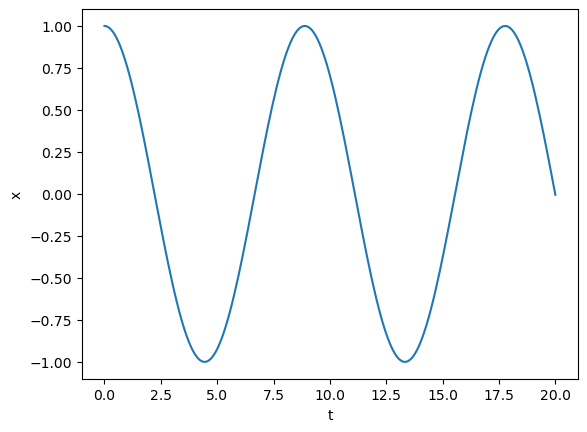

In [2]:
k=0.5; m = 1.0; x0=1.0;  #assign parameter values
def dZ_dt(Z, t):
    # Here Z is a vector such that x=Z[0] and y=Z[1]. This function should return [x’, y’]
    x=Z[0]
    y=Z[1]
    return [y, - k/m*x]
Z0 = [x0, 0]
ts = np.linspace(0, 20, 200) #integrate from t=0 to t=20
Zs = odeint(dZ_dt, Z0, ts)
xs = Zs[:,0]
plt.plot(ts,xs)
plt.xlabel('t')
plt.ylabel('x')
plt.show()

In [3]:
# problem 1

##### Parameters #####

e_l = -54.4  # mV
e_k = -77.0  # mV
e_na = 50.0  # mV
g_l = 0.3    # mS/cm^2
g_k = 36.0   # mS/cm^2
g_na = 120.0 # mS/cm^2
c_m = 1.0    # uF/cm^2

A = 1 # cm^2

# time vector
t_start = 0.0  # ms
t_end = 50.0   # ms
dt = 0.01      # ms
time = np.arange(t_start, t_end, dt)

# equations for alpha and beta
def alpha_m(V):
    return (0.1*(V+40.0)) / (1.0 - np.exp(-0.1*(V+40.0)))
def alpha_h(V):
    return 0.07 * np.exp(-0.05*(V+65.0))
def alpha_n(V):
    return (0.01*(V+55.0)) / (1.0 - np.exp(-0.1*(V+55.0)))

def beta_m(V):
    return 4.0 * np.exp(-0.0556*(V+65.0))
def beta_h(V):
    return 1.0 / (1.0 + np.exp(-0.1*(V+35.0)))
def beta_n(V):
    return 0.125 * np.exp(-0.0125*(V+65.0))

# V vector with stems between -100 mV and 20 mV
V = np.linspace(-100, 20, 1000)

# dynamic equations
def tau_x(V, alpha_x, beta_x):
    return 1.0 / (alpha_x(V) + beta_x(V))

def x_inf(V, alpha_x, beta_x):
    return alpha_x(V) / (alpha_x(V) + beta_x(V))

def dx_dt(x, V, alpha_x, beta_x):
    return (x_inf(V, alpha_x, beta_x) - x) / tau_x(V, alpha_x, beta_x)


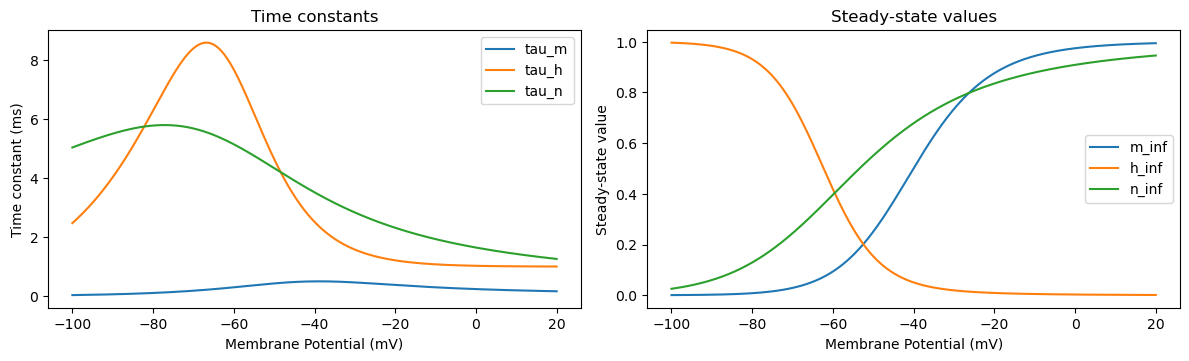

In [4]:
# plot the dynamics
plt.figure(figsize=(12, 10))
plt.subplot(3, 2, 2)
plt.plot(V, x_inf(V, alpha_m, beta_m), label='m_inf')
plt.plot(V, x_inf(V, alpha_h, beta_h), label='h_inf')
plt.plot(V, x_inf(V, alpha_n, beta_n), label='n_inf')
plt.title('Steady-state values')
plt.xlabel('Membrane Potential (mV)')
plt.ylabel('Steady-state value')
plt.legend()
plt.subplot(3, 2, 1)
plt.plot(V, tau_x(V, alpha_m, beta_m), label='tau_m')
plt.plot(V, tau_x(V, alpha_h, beta_h), label='tau_h')
plt.plot(V, tau_x(V, alpha_n, beta_n), label='tau_n')
plt.title('Time constants')
plt.xlabel('Membrane Potential (mV)')
plt.ylabel('Time constant (ms)')
plt.legend()
plt.tight_layout()
plt.show()  



tau_h: The time constant tau_h represents the time it takes for the inactivation of sodium channels, a smaller tau_h means the channels inactivate more quickly, affecting the duration and frequency of action potentials.

tau_m: The time constant tau_m represents the time it takes for the activation of sodium channels

tau_n: The time constant tau_n represents the time it takes for the activation of potassium channels


h_inf: The steady-state value h_inf is the fraction of sodium channels not inactivated at a given membrane potential.

m_inf: The steady-state value m_inf is the fraction of sodium channels that are open at a given membrane potential.

n_inf: The steady-state value n_inf is the fraction of potassium channels that are open at a given membrane potential.


# discussion:
The steady-state values indicate the proportion of ion channels that are open at a given membrane potential.

The time constants indicate how quickly the gating variables approach their steady-state values at different membrane potentials.

The sequence of gating variables during action potional replicates the changing ion channel states (opening in case of potassium and chloride, closing in case of sodium, h)

The difficult part to tell here is how these relate to action potentials as we don't really know whether the current is  moving inward or outward without knowing quite a bit about the ions and their potentials in neurons, rather we just know that the ion channel states are allowing more or less ions to move through.

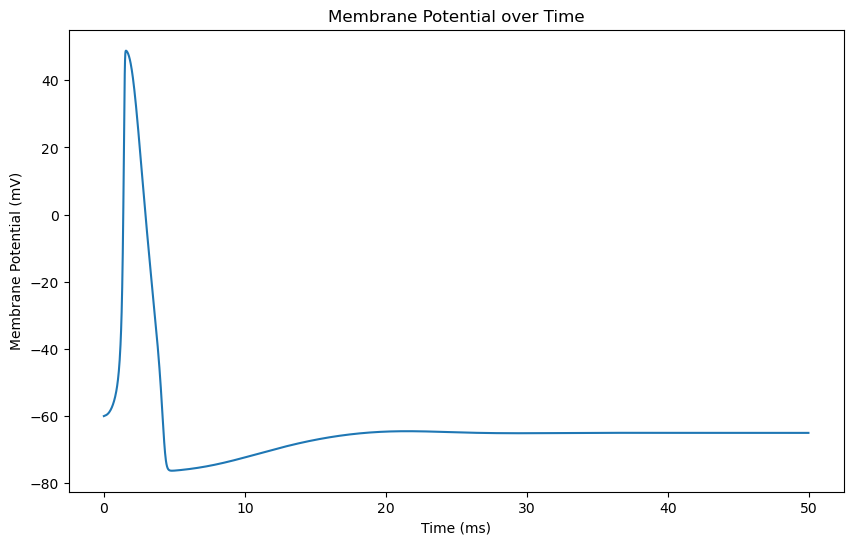

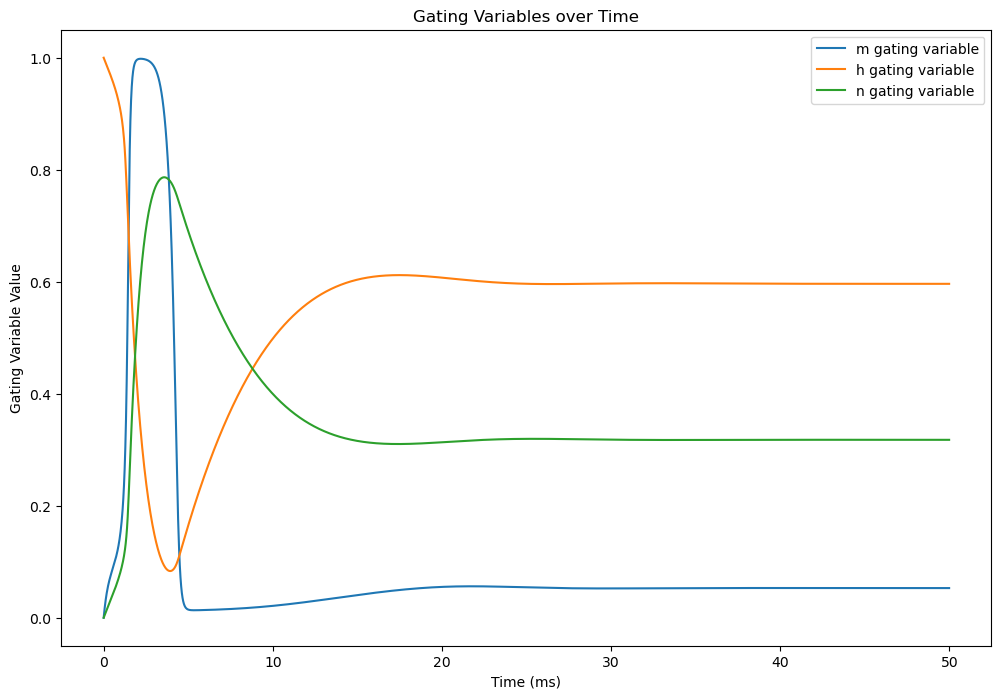

In [ ]:
# C: simulating the complete model for 50 ms 
# initial conditions
V0 = -65.0  # mV
m0 = 0.0
h0 = 1.0
n0 = 0.0
Ie = 0.0

def dALL_dt(Y, t, Ie):
    V, m, h, n = Y

    # Ionic currents
    I_na = g_na * (m**3) * h * (V - e_na)
    I_k = g_k * (n**4) * (V - e_k)
    I_l = g_l * (V - e_l)

    I_m = I_na + I_k + I_l

    # dV/dt
    dVdt = (-I_m + (Ie/A)) / c_m
    #print(dVdt)

    # Gating variable dynamics
    dmdt = dx_dt(m, V, alpha_m, beta_m)
    dhdt = dx_dt(h, V, alpha_h, beta_h)
    dndt = dx_dt(n, V, alpha_n, beta_n)

    return [dVdt, dmdt, dhdt, dndt]

Y0 = [V0, m0, h0, n0]
# using our euler step to integrate the system
Ys = np.zeros((len(time), 4))
Ys[0] = Y0
for i in range(1, len(time)):
    dt = time[i] - time[i-1]
    #print(dt)
    Y_prev = Ys[i-1]
    dY = dALL_dt(Y_prev, time[i-1], Ie)
    Ys[i] = Y_prev + np.array(dY) * dt
Vs = Ys[:, 0]
ms = Ys[:, 1]
hs = Ys[:, 2]
ns = Ys[:, 3]
plt.figure(figsize=(10, 6))
plt.plot(time, Vs)
plt.title('Membrane Potential over Time')
plt.xlabel('Time (ms)')
plt.ylabel('Membrane Potential (mV)')
plt.show()


plt.figure(figsize=(12, 8))
plt.plot(time, ms, label='m gating variable')
plt.plot(time, hs, label='h gating variable')
plt.plot(time, ns, label='n gating variable')
plt.legend()
plt.title('Gating Variables over Time')
plt.xlabel('Time (ms)')
plt.ylabel('Gating Variable Value')
plt.show()

In [ ]:
# multiple spikes
# change range 

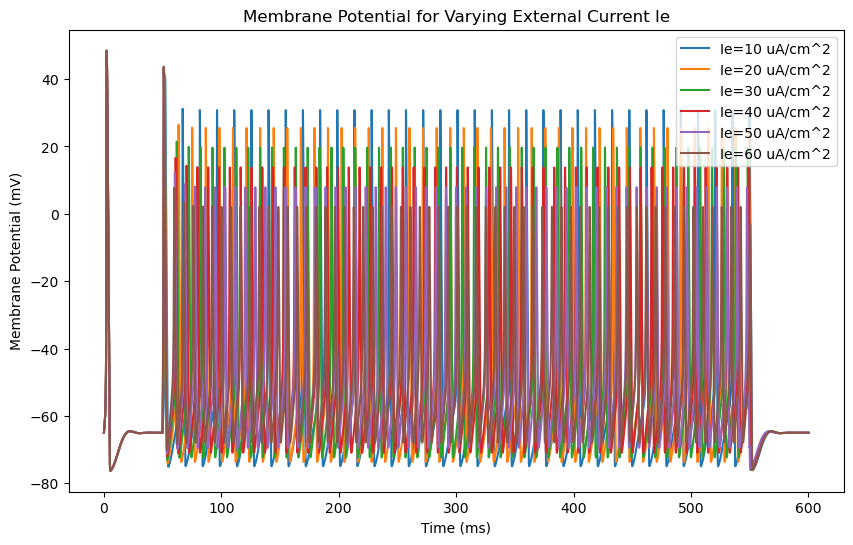

In [6]:
# D: effect of varying external current Ie
Ie_vals = np.arange(0, 61, 5) # microAmpere

# input lasts 600 ms, external input is introduced at t=50ms, same initial conditions
voltage_traces = []
firing_rates = []
for Ie in Ie_vals:
    t_start = 0.0  # ms
    t_end = 600.0   # ms
    dt = 0.01      # ms
    time = np.arange(t_start, t_end, dt)

    Y0 = [V0, m0, h0, n0]
    def dALL_dt_time_dependent(Y, t):
        if 50.0 <= t <= 550.0:
            Ie_current = Ie
        else:
            Ie_current = 0.0
        return dALL_dt(Y, t, Ie_current)

    # using our euler step to integrate the system
    Ys = np.zeros((len(time), 4))
    Ys[0] = Y0
    for i in range(1, len(time)):
        dt = time[i] - time[i-1]
        Y_prev = Ys[i-1]
        dY = dALL_dt_time_dependent(Y_prev, time[i-1])
        Ys[i] = Y_prev + np.array(dY) * dt
    Vs = Ys[:, 0]

    # firing rate
    # where spikes are 
    spike_vector = np.sum((Vs[:-1] < 0) & (Vs[1:] >= 0))
    hz_rate = ((t_end - t_start) / 1000)
    firing_rates.append(spike_vector / hz_rate)  # spikes per second
    voltage_traces.append(Vs)

plt.figure(figsize=(10, 6))
for i, Ie in enumerate(Ie_vals):
    #plt.plot(time, voltage_traces[i], label=f'Ie={Ie} uA/cm^2')
    if Ie in [10, 20, 30, 40, 50, 60]:
        plt.plot(time, voltage_traces[i], label=f'Ie={Ie} uA/cm^2')
    
plt.title('Membrane Potential for Varying External Current Ie')
plt.legend()
plt.xlabel('Time (ms)')
plt.ylabel('Membrane Potential (mV)')
plt.show()

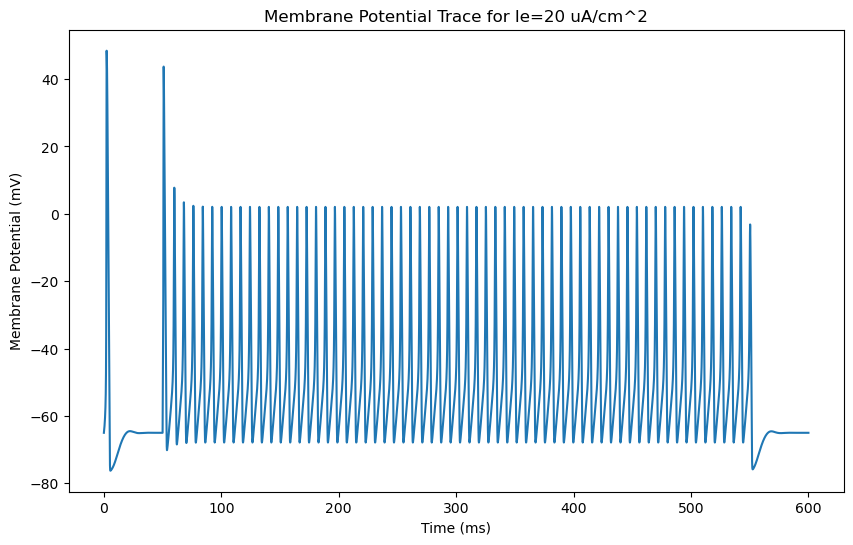

In [7]:
# Example traces
plt.figure(figsize=(10, 6))
plt.plot(time, voltage_traces[-1], label=f'Ie={Ie} uA/cm^2')
plt.title('Membrane Potential Trace for Ie=20 uA/cm^2')
plt.xlabel('Time (ms)')
plt.ylabel('Membrane Potential (mV)')
plt.show()

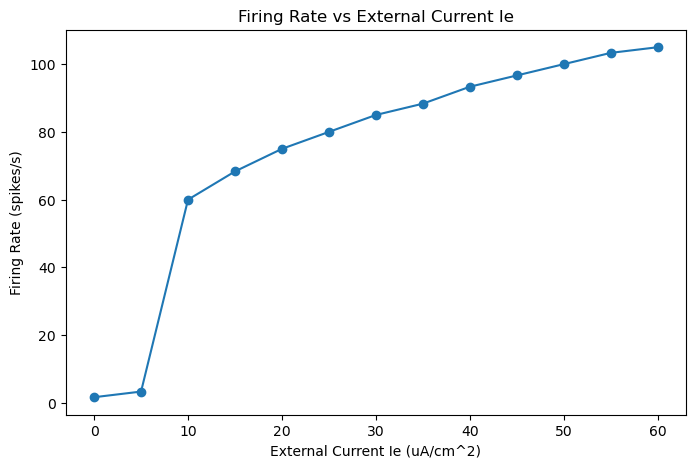

In [8]:
# firing rate vs Ie
plt.figure(figsize=(8, 5))
plt.plot(Ie_vals, firing_rates, marker='o')
plt.title('Firing Rate vs External Current Ie')
plt.xlabel('External Current Ie (uA/cm^2)')
plt.ylabel('Firing Rate (spikes/s)')
plt.show()

In [9]:
# dicussion:
''' Spike at the beginning of the simulation before Ie current occurs due to the initial conditions set in the model. 
'''

' Spike at the beginning of the simulation before Ie current occurs due to the initial conditions set in the model. \n'

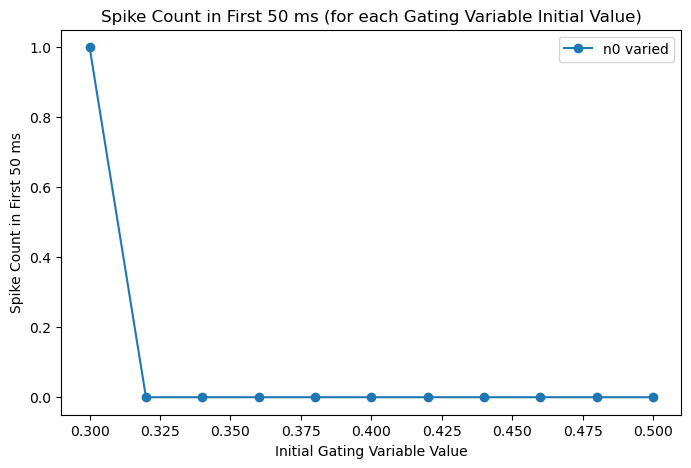

In [10]:
# Testing initial parameters to stop the neuron from spiking at the beginning


# measure spike count in the first 50 ms for a range of m0 values and plot the results as a function of m0
m0_values = np.linspace(0, 1, 11)
n0_values = np.linspace(0.3, 0.5, 11)
h0_values = np.linspace(0, 1, 11)

Ie = 0.0  # microAmpere
t_start = 0.0  # ms
t_end = 50.0   # ms
dt = 0.02      # ms

spike_counts_m = []
spike_counts_n = []
spike_counts_h = []
# for m0_test in m0_values:

#     time = np.arange(t_start, t_end, dt)

#     Y0 = [V0, m0_test, h0, n0]
#     def dALL_dt_time_dependent(Y, t):
#         return dALL_dt(Y, t, Ie)

#     Ys = odeint(dALL_dt_time_dependent, Y0, time)
#     Vs = Ys[:, 0]

#     spike_vector = np.sum((Vs[:-1] < 0) & (Vs[1:] >= 0))
#     spike_counts_m.append(spike_vector)


for n0_test in n0_values:

    time = np.arange(t_start, t_end, dt)

    Y0 = [V0, m0, h0, n0_test]
    def dALL_dt_time_dependent(Y, t):
        return dALL_dt(Y, t, Ie)

    Ys = np.zeros((len(time), 4))
    Ys[0] = Y0
    for i in range(1, len(time)):
        dt = time[i] - time[i-1]
        Y_prev = Ys[i-1]
        dY = dALL_dt_time_dependent(Y_prev, time[i-1])
        Ys[i] = Y_prev + np.array(dY) * dt
    Vs = Ys[:, 0]

    spike_vector = np.sum((Vs[:-1] < 0) & (Vs[1:] >= 0))
    spike_counts_n.append(spike_vector)


# for h0_test in h0_values:

#     time = np.arange(t_start, t_end, dt)

#     Y0 = [V0, m0, h0_test, n0]
#     def dALL_dt_time_dependent(Y, t):
#         return dALL_dt(Y, t, Ie)

#     Ys = odeint(dALL_dt_time_dependent, Y0, time)
#     Vs = Ys[:, 0]

#     spike_vector = np.sum((Vs[:-1] < 0) & (Vs[1:] >= 0))
#     spike_counts_h.append(spike_vector)
plt.figure(figsize=(8, 5))
#plt.plot(m0_values, spike_counts_m, marker='o', label = 'm0 varied')
plt.plot(n0_values, spike_counts_n, marker='o', label = 'n0 varied')
#plt.plot(h0_values, spike_counts_h, marker='o', label = 'h0 varied')
plt.title('Spike Count in First 50 ms (for each Gating Variable Initial Value)')
plt.xlabel('Initial Gating Variable Value')
plt.ylabel('Spike Count in First 50 ms')
plt.legend()
plt.show()




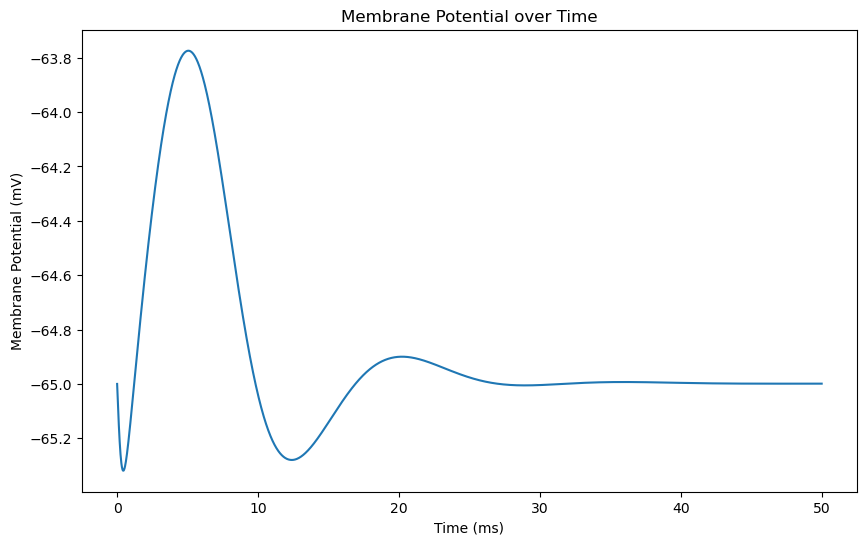

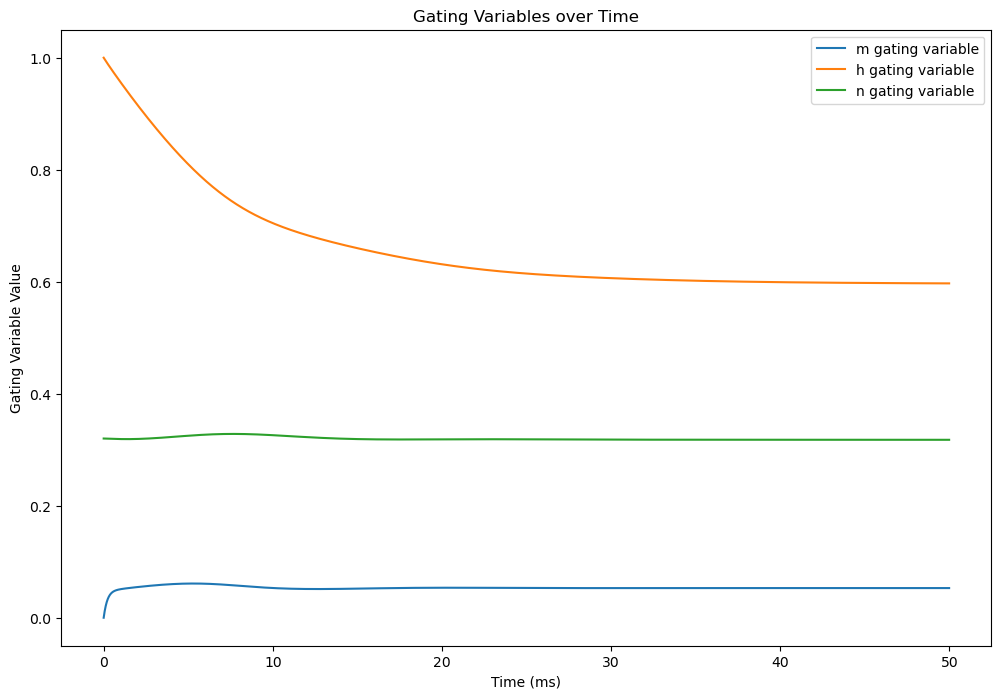

In [11]:
# initial conditions
V0 = -65.0  # mV
m0 = 0.0
h0 = 1.0
n0 = 0.32
Ie = 0.0

def dALL_dt(Y, t, Ie):
    V, m, h, n = Y

    # Ionic currents
    I_na = g_na * (m**3) * h * (V - e_na)
    I_k = g_k * (n**4) * (V - e_k)
    I_l = g_l * (V - e_l)

    I_m = I_na + I_k + I_l

    # dV/dt
    dVdt = (-I_m + (Ie/A)) / c_m

    # Gating variable dynamics
    dmdt = dx_dt(m, V, alpha_m, beta_m)
    dhdt = dx_dt(h, V, alpha_h, beta_h)
    dndt = dx_dt(n, V, alpha_n, beta_n)

    return [dVdt, dmdt, dhdt, dndt]

Y0 = [V0, m0, h0, n0]
Ys = odeint(dALL_dt, Y0, time, args=(Ie,))
Vs = Ys[:, 0]
ms = Ys[:, 1]
hs = Ys[:, 2]
ns = Ys[:, 3]
plt.figure(figsize=(10, 6))
plt.plot(time, Vs)
plt.title('Membrane Potential over Time')
plt.xlabel('Time (ms)')
plt.ylabel('Membrane Potential (mV)')
plt.show()


plt.figure(figsize=(12, 8))
plt.plot(time, ms, label='m gating variable')
plt.plot(time, hs, label='h gating variable')
plt.plot(time, ns, label='n gating variable')
plt.legend()
plt.title('Gating Variables over Time')
plt.xlabel('Time (ms)')
plt.ylabel('Gating Variable Value')
plt.show()

In [ ]:
# Backwards Euler for the voltages
def dy_dt_backwards(y, t):
    return t - y

# Create a backwards euler solver
def b_euler_step(y, t, dt):
    return y - dy_dt_backwards(y, t)*dt

# backward euler equations

def m_backwards

IndentationError: expected an indented block after function definition on line 2 (1376524914.py, line 6)